In [1]:
from pathlib import Path
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile

# Rutas base
ROOT = Path.cwd().resolve().parent if Path.cwd().name == "notebooks" else Path.cwd()
RAW = ROOT / "data" / "raw" / "energy_spain"
RAW.mkdir(parents=True, exist_ok=True)
print("Destino:", RAW)

# Autenticación Kaggle 
api = KaggleApi()
api.authenticate()

# Descargar ZIP del dataset a la carpeta RAW
dataset_slug = "manualrg/spanish-electricity-market-demand-gen-price"
print("Descargando:", dataset_slug)
api.dataset_download_files(dataset_slug, path=RAW, force=True, quiet=False)

# Descomprimir el ZIP más nuevo (Kaggle usa .zip cuando hay varios archivos)
zips = sorted(RAW.glob("*.zip"), key=lambda p: p.stat().st_mtime, reverse=True)
if zips:
    zip_path = zips[0]
    print("Descomprimiendo:", zip_path.name)
    with ZipFile(zip_path, "r") as zf:
        zf.extractall(RAW)
    try:
        zip_path.unlink()
    except Exception:
        pass

print("Descarga completada")

Destino: C:\Users\Usuario\OneDrive\Desktop\Penguin\analisis-de-datos\data\raw\energy_spain
Descargando: manualrg/spanish-electricity-market-demand-gen-price
Dataset URL: https://www.kaggle.com/datasets/manualrg/spanish-electricity-market-demand-gen-price


100%|██████████| 285k/285k [00:00<00:00, 92.0MB/s]


Descomprimiendo: spanish-electricity-market-demand-gen-price.zip
Descarga completada


In [2]:
import pandas as pd

def listar_archivos(carpeta: Path, exts=(".csv", ".parquet", ".xls", ".xlsx")):
    filas = []
    for p in carpeta.rglob("*"):
        if p.is_file() and p.suffix.lower() in exts:
            filas.append({"archivo": str(p.relative_to(carpeta)),
                          "tam_mb": round(p.stat().st_size/1_000_000, 3)})
    return pd.DataFrame(filas).sort_values("archivo")

display(listar_archivos(RAW))

,archivo,tam_mb
0,spain_energy_market.csv,3.131


In [4]:
import pandas as pd

# Detectar el primer CSV que haya
csvs = sorted(RAW.glob("*.csv"))
assert csvs, "No se encontraron CSVs en la carpeta de España."
csv_path = csvs[0]
print("Leyendo:", csv_path.name)

# Cargar el CSV con manejo de posibles errores de codificación
try:
    df_es = pd.read_csv(csv_path, low_memory=False)
except UnicodeDecodeError:
    df_es = pd.read_csv(csv_path, encoding="latin-1", low_memory=False)

display(df_es.head(5))
print("Shape:", df_es.shape)
print("Columnas:", list(df_es.columns))
display(df_es.dtypes.to_frame("dtype"))

Leyendo: spain_energy_market.csv


,datetime,id,name,geoid,geoname,value
0,2014-01-01 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,25.280833
1,2014-01-02 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,39.924167
2,2014-01-03 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,4.992083
3,2014-01-04 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,4.091667
4,2014-01-05 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,13.587500


Shape: (40212, 6)
Columnas: ['datetime', 'id', 'name', 'geoid', 'geoname', 'value']


,dtype
datetime,object
id,int64
name,object
geoid,float64
geoname,object
value,float64


In [5]:
import pandas as pd
from pathlib import Path

# === Configuración ===
ROOT = Path.cwd().resolve().parent if Path.cwd().name == "notebooks" else Path.cwd()
REPORTS = ROOT / "reports" / "tables"
REPORTS.mkdir(parents=True, exist_ok=True)

# === Crear un resumen de columnas ===
diccionario_es = pd.DataFrame({
    "columna": df_es.columns,
    "tipo_dato": [df_es[c].dtype for c in df_es.columns],
    "valores_nulos": [df_es[c].isna().sum() for c in df_es.columns],
    "porcentaje_nulos": [round(df_es[c].isna().mean()*100, 2) for c in df_es.columns],
    "ejemplo_valor": [df_es[c].dropna().iloc[0] if df_es[c].notna().any() else None for c in df_es.columns]
})

# Guardar en reports/tables/
out = REPORTS / "spain_diccionario.csv"
diccionario_es.to_csv(out, index=False)
print(f"Diccionario rápido guardado en: {out}")
display(diccionario_es)


Diccionario rápido guardado en: C:\Users\Usuario\OneDrive\Desktop\Penguin\analisis-de-datos\reports\tables\spain_diccionario.csv


,columna,tipo_dato,valores_nulos,porcentaje_nulos,ejemplo_valor
0,datetime,object,0,0.00,2014-01-01 23:00:00
1,id,int64,0,0.00,600
2,name,object,5478,13.62,Precio mercado SPOT Diario ESP
3,geoid,float64,29256,72.75,3.0
4,geoname,object,29256,72.75,España
5,value,float64,0,0.00,25.280833


In [6]:
df_es["datetime"] = pd.to_datetime(df_es["datetime"])
df_es = df_es.sort_values("datetime")
df_es.info()


<class 'pandas.core.frame.DataFrame'>
Index: 40212 entries, 0 to 40211
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  40212 non-null  datetime64[ns]
 1   id        40212 non-null  int64         
 2   name      34734 non-null  object        
 3   geoid     10956 non-null  float64       
 4   geoname   10956 non-null  object        
 5   value     40212 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 2.1+ MB


In [7]:
df_es["name"].value_counts()

name
Precio mercado SPOT Diario ESP                                            1826
Energía asignada en Mercado SPOT Diario España                            1826
Generación programada PBF Solar fotovoltaica                              1826
Generación programada PBF UGH + no UGH                                    1826
Precio mercado SPOT Diario FRA                                            1826
Energía asignada en Mercado SPOT Diario Francia                           1826
Precio mercado SPOT Diario POR                                            1826
Generación programada PBF Gas Natural Cogeneración                        1826
Generación programada PBF Eólica                                          1825
Generación programada PBF Nuclear                                         1825
Generación programada PBF total                                           1825
Demanda real                                                              1825
Demanda programada PBF total                   

In [8]:
df_wide = df_es.pivot_table(
    index="datetime",
    columns="name",
    values="value"
)
df_wide.head()


name,Demanda programada PBF total,Demanda real,Energía asignada en Mercado SPOT Diario España,Energía asignada en Mercado SPOT Diario Francia,Generación programada PBF Carbón,Generación programada PBF Ciclo combinado,Generación programada PBF Eólica,Generación programada PBF Gas Natural Cogeneración,Generación programada PBF Nuclear,Generación programada PBF Solar fotovoltaica,Generación programada PBF Turbinación bombeo,Generación programada PBF UGH + no UGH,Generación programada PBF total,Precio mercado SPOT Diario ESP,Precio mercado SPOT Diario FRA,Precio mercado SPOT Diario POR,Rentas de congestión mecanismos implícitos diario Francia exportación,Rentas de congestión mecanismos implícitos diario Francia importación,Rentas de congestión mecanismos implícitos diario Portugal exportación,Rentas de congestión mecanismos implícitos diario Portugal importación
datetime,,,,,,,,,,,,,,,,,,,,
2014-01-01 23:00:00,620107.7,28191.597222,566081.9,171917.3,2498.7,4497.5,277443.9,75993.1,144654.6,7027.3,15226.2,87564.8,642771.8,25.280833,28.71125,25.043750,NaN,NaN,NaN,10811.0
2014-01-02 23:00:00,659865.2,28465.180556,586355.6,164386.5,19741.4,14541.1,237323.1,83437.4,146177.8,12817.8,21979.8,94432.6,658078.5,39.924167,28.39750,38.980417,NaN,NaN,NaN,43035.0
2014-01-03 23:00:00,632536.8,26860.493056,609612.9,166611.2,1288.0,3555.6,329506.6,65023.9,145055.3,12532.5,3192.2,92236.2,680564.6,4.992083,12.99750,4.683750,NaN,NaN,NaN,14060.0
2014-01-04 23:00:00,610251.7,25333.597222,605090.0,156271.4,NaN,2310.2,292138.3,64036.6,145200.2,14108.3,4540.8,94189.3,644494.7,4.091667,23.08500,4.091667,NaN,NaN,0.0,0.0
2014-01-05 23:00:00,572534.1,23905.541667,531020.2,170611.0,2687.0,6297.0,223942.0,74151.3,135624.0,14555.6,5165.4,103851.1,598661.4,13.587500,31.29000,12.762500,NaN,NaN,NaN,37620.0


In [11]:
rename_map = {
    "Precio mercado SPOT Diario ESP": "price_es",
    "Demanda real": "demand_es",
    "Generación programada PBF total": "generation_total",
    "Generación programada PBF Eólica": "generation_wind",
    "Generación programada PBF Solar fotovoltaica": "generation_solar",
    "Generación programada PBF Nuclear": "generation_nuclear",
    "Generación programada PBF Gas Natural Cogeneración": "generation_gas",
    "Generación programada PBF Ciclo combinado": "generation_cycle",
    "Generación programada PBF Carbón": "generation_coal",
    "Generación programada PBF UGH + no UGH": "generation_hydro",
    "Generación programada PBF Turbinación bombeo": "generation_pumped",
    "Demanda programada PBF total": "demand_programmed",
    "Energía asignada en Mercado SPOT Diario España": "assigned_spot_es",
    "Energía asignada en Mercado SPOT Diario Francia": "assigned_spot_fr",
    "Precio mercado SPOT Diario FRA": "price_fr",
    "Precio mercado SPOT Diario POR": "price_pt",
}
df_wide = df_wide.rename(columns=rename_map)
df_wide.head()

name,demand_programmed,demand_es,assigned_spot_es,assigned_spot_es,generation_coal,generation_cycle,generation_wind,generation_gas,generation_nuclear,generation_solar,generation_pumped,generation_hydro,generation_total,price_es,price_fr,price_pt,Rentas de congestión mecanismos implícitos diario Francia exportación,Rentas de congestión mecanismos implícitos diario Francia importación,Rentas de congestión mecanismos implícitos diario Portugal exportación,Rentas de congestión mecanismos implícitos diario Portugal importación
datetime,,,,,,,,,,,,,,,,,,,,
2014-01-01 23:00:00,620107.7,28191.597222,566081.9,171917.3,2498.7,4497.5,277443.9,75993.1,144654.6,7027.3,15226.2,87564.8,642771.8,25.280833,28.71125,25.043750,NaN,NaN,NaN,10811.0
2014-01-02 23:00:00,659865.2,28465.180556,586355.6,164386.5,19741.4,14541.1,237323.1,83437.4,146177.8,12817.8,21979.8,94432.6,658078.5,39.924167,28.39750,38.980417,NaN,NaN,NaN,43035.0
2014-01-03 23:00:00,632536.8,26860.493056,609612.9,166611.2,1288.0,3555.6,329506.6,65023.9,145055.3,12532.5,3192.2,92236.2,680564.6,4.992083,12.99750,4.683750,NaN,NaN,NaN,14060.0
2014-01-04 23:00:00,610251.7,25333.597222,605090.0,156271.4,NaN,2310.2,292138.3,64036.6,145200.2,14108.3,4540.8,94189.3,644494.7,4.091667,23.08500,4.091667,NaN,NaN,0.0,0.0
2014-01-05 23:00:00,572534.1,23905.541667,531020.2,170611.0,2687.0,6297.0,223942.0,74151.3,135624.0,14555.6,5165.4,103851.1,598661.4,13.587500,31.29000,12.762500,NaN,NaN,NaN,37620.0


In [13]:
from pathlib import Path

ROOT = Path.cwd().resolve().parent if Path.cwd().name == "notebooks" else Path.cwd()
CLEAN = ROOT / "data" / "processed"
CLEAN.mkdir(parents=True, exist_ok=True)

out_path = CLEAN / "energy_spain_clean.csv"
df_wide.to_csv(out_path)
print("Dataset limpio guardado en:", out_path)

Dataset limpio guardado en: C:\Users\Usuario\OneDrive\Desktop\Penguin\analisis-de-datos\data\processed\energy_spain_clean.csv


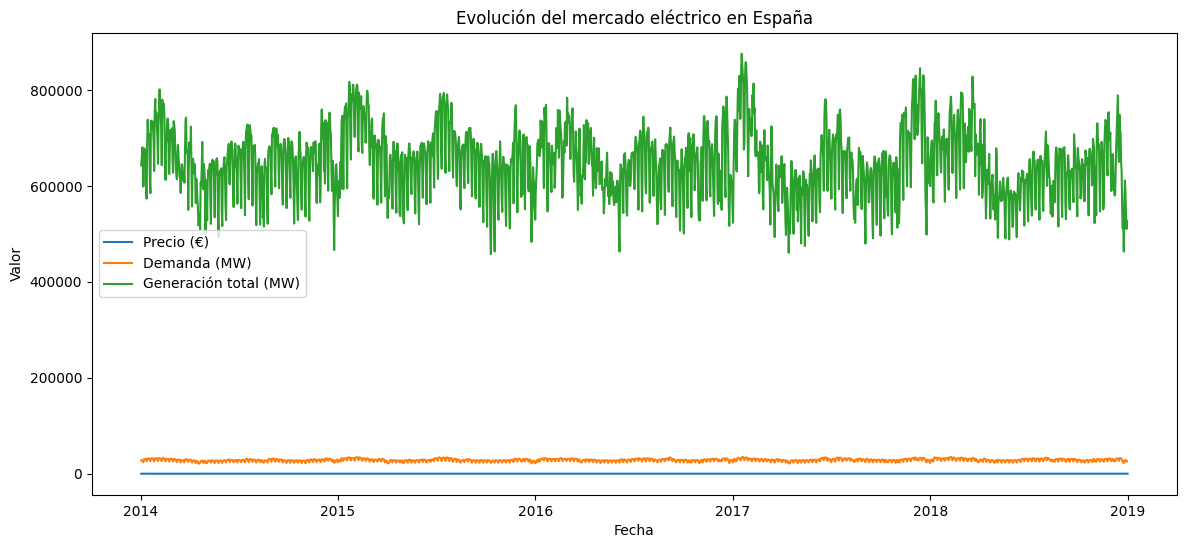

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
sns.lineplot(data=df_wide, x=df_wide.index, y="price_es", label="Precio (€)")
sns.lineplot(data=df_wide, x=df_wide.index, y="demand_es", label="Demanda (MW)")
sns.lineplot(data=df_wide, x=df_wide.index, y="generation_total", label="Generación total (MW)")
plt.title("Evolución del mercado eléctrico en España")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.show()


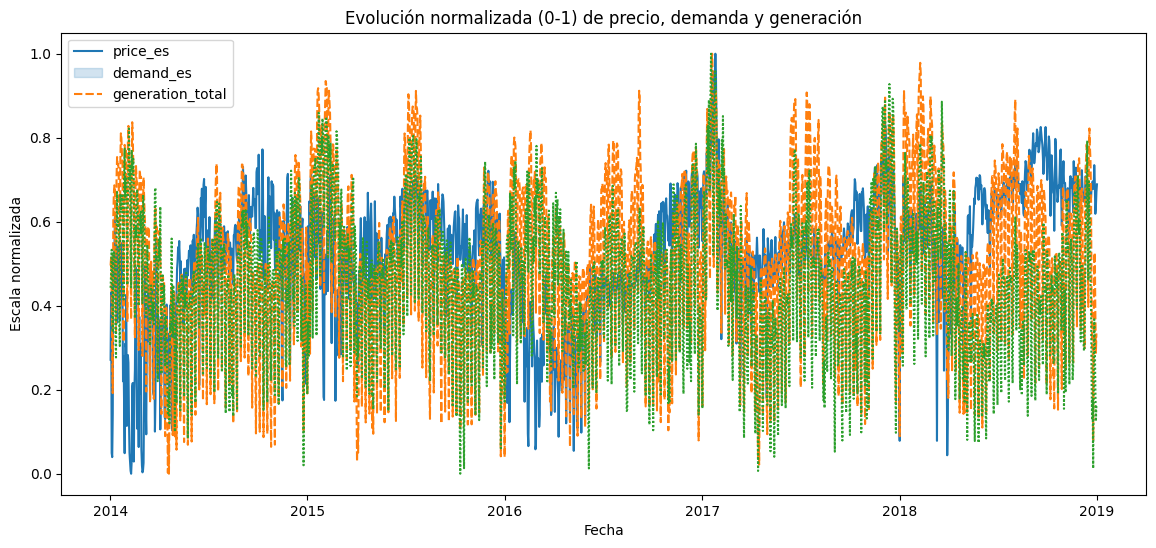

In [15]:
# Normalizar las series para compararlas en la misma escala (0-1)
df_norm = (df_wide[["price_es","demand_es","generation_total"]] - df_wide[["price_es","demand_es","generation_total"]].min()) / \
           (df_wide[["price_es","demand_es","generation_total"]].max() - df_wide[["price_es","demand_es","generation_total"]].min())

plt.figure(figsize=(14,6))
sns.lineplot(data=df_norm)
plt.title("Evolución normalizada (0-1) de precio, demanda y generación")
plt.xlabel("Fecha")
plt.ylabel("Escala normalizada")
plt.legend(df_norm.columns)
plt.show()


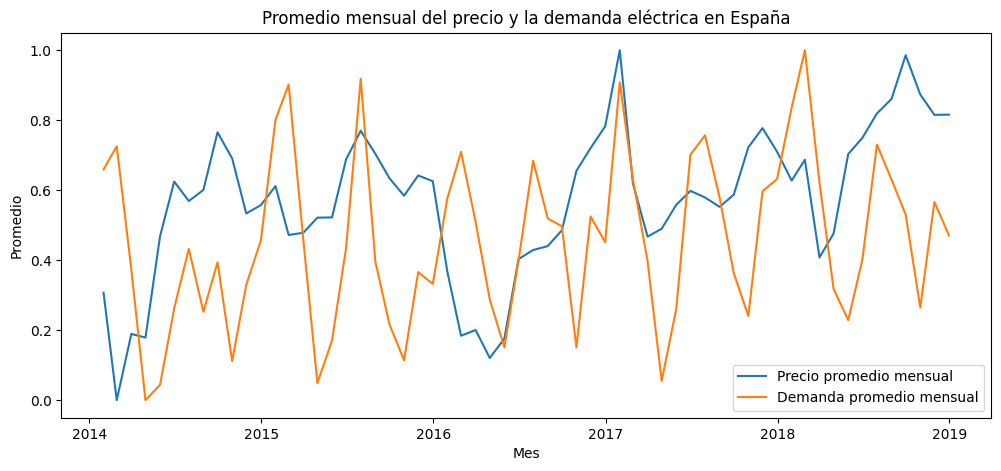

In [20]:
df_monthly = df_wide.resample("ME").mean()

df_norm = (df_monthly[["price_es","demand_es"]] - df_monthly[["price_es","demand_es"]].min()) / \
           (df_monthly[["price_es","demand_es"]].max() - df_monthly[["price_es","demand_es"]].min())

plt.figure(figsize=(12,5))
sns.lineplot(data=df_norm, x=df_norm.index, y="price_es", label="Precio promedio mensual")
sns.lineplot(data=df_norm, x=df_norm.index, y="demand_es", label="Demanda promedio mensual")
plt.title("Promedio mensual del precio y la demanda eléctrica en España")
plt.xlabel("Mes")
plt.ylabel("Promedio")
plt.legend()
plt.show()


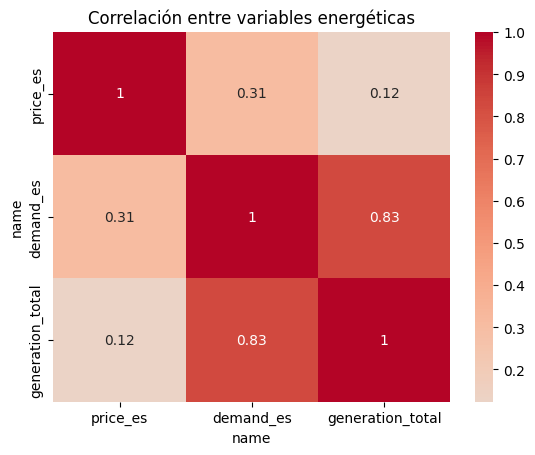

In [21]:
# Matriz de correlación
corr = df_wide[["price_es","demand_es","generation_total"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlación entre variables energéticas")
plt.show()